Goal:
- Demonstrate SVM with Gaussian Kernel

Subgoals:
- Find (and show) dataset
- Derive formulae needed
- Illustrate how classification can be done with Scikit-Learn (not valid for homework, but great for checking answers!)

We're going to use Scikit-Learn and Seaborn, so I need to install those.
```
conda install -c conda-forge scikit-learn seaborn
```

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset Exploration

### Iris Dataset

First: the [classic Iris](https://archive.ics.uci.edu/dataset/53/iris) dataset. I've already downloaded it and included it in the repository. It's got four features and a class variable. I'll first load the data, then generate a confusion plot.

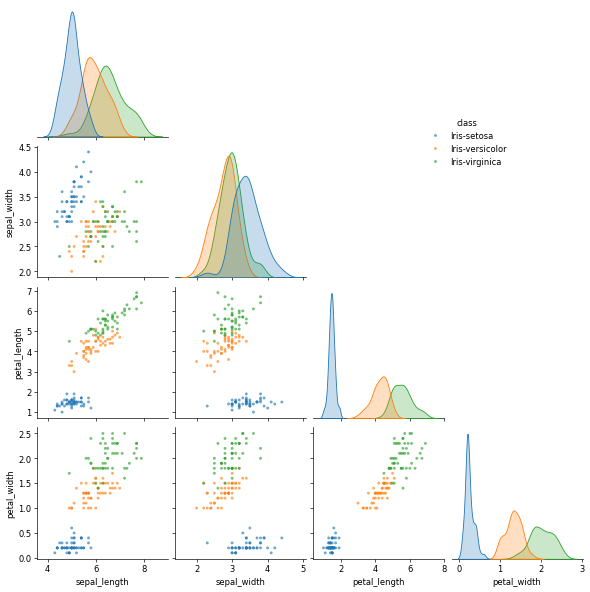

In [44]:
df = pd.read_csv("iris/iris.data", 
                 header=None,
                 names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])  # From iris.names

g = sns.pairplot(
    df,
    hue="class",
    corner=True,
    plot_kws=dict(s=12, linewidth=0, alpha=0.65)
)

g._legend.set_bbox_to_anchor((0.75,0.75))  # Move legend in

g.figure.set_dpi(60)  # Change to 300 for recitation
plt.show();

Since the iris-setosa seems to be pretty different, we'll just consider the iris-versicolor and the iris-virginica.

### BCWD Dataset

We'll look at the [classic Breast Cancer Wisconsin](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) dataset. I've already downloaded it and included it in the repository. It's got 30 features and a boolean class variable (B or M for Malignant or Benign). I'll first load the data, then generate a confusion plot.

I've downloaded it, but since found that [scikit-learn already has the data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). 

In [45]:
df = pd.read_csv("breast_cancer_wisconsin_diagnostic/wdbc.data", 
                 header=None)

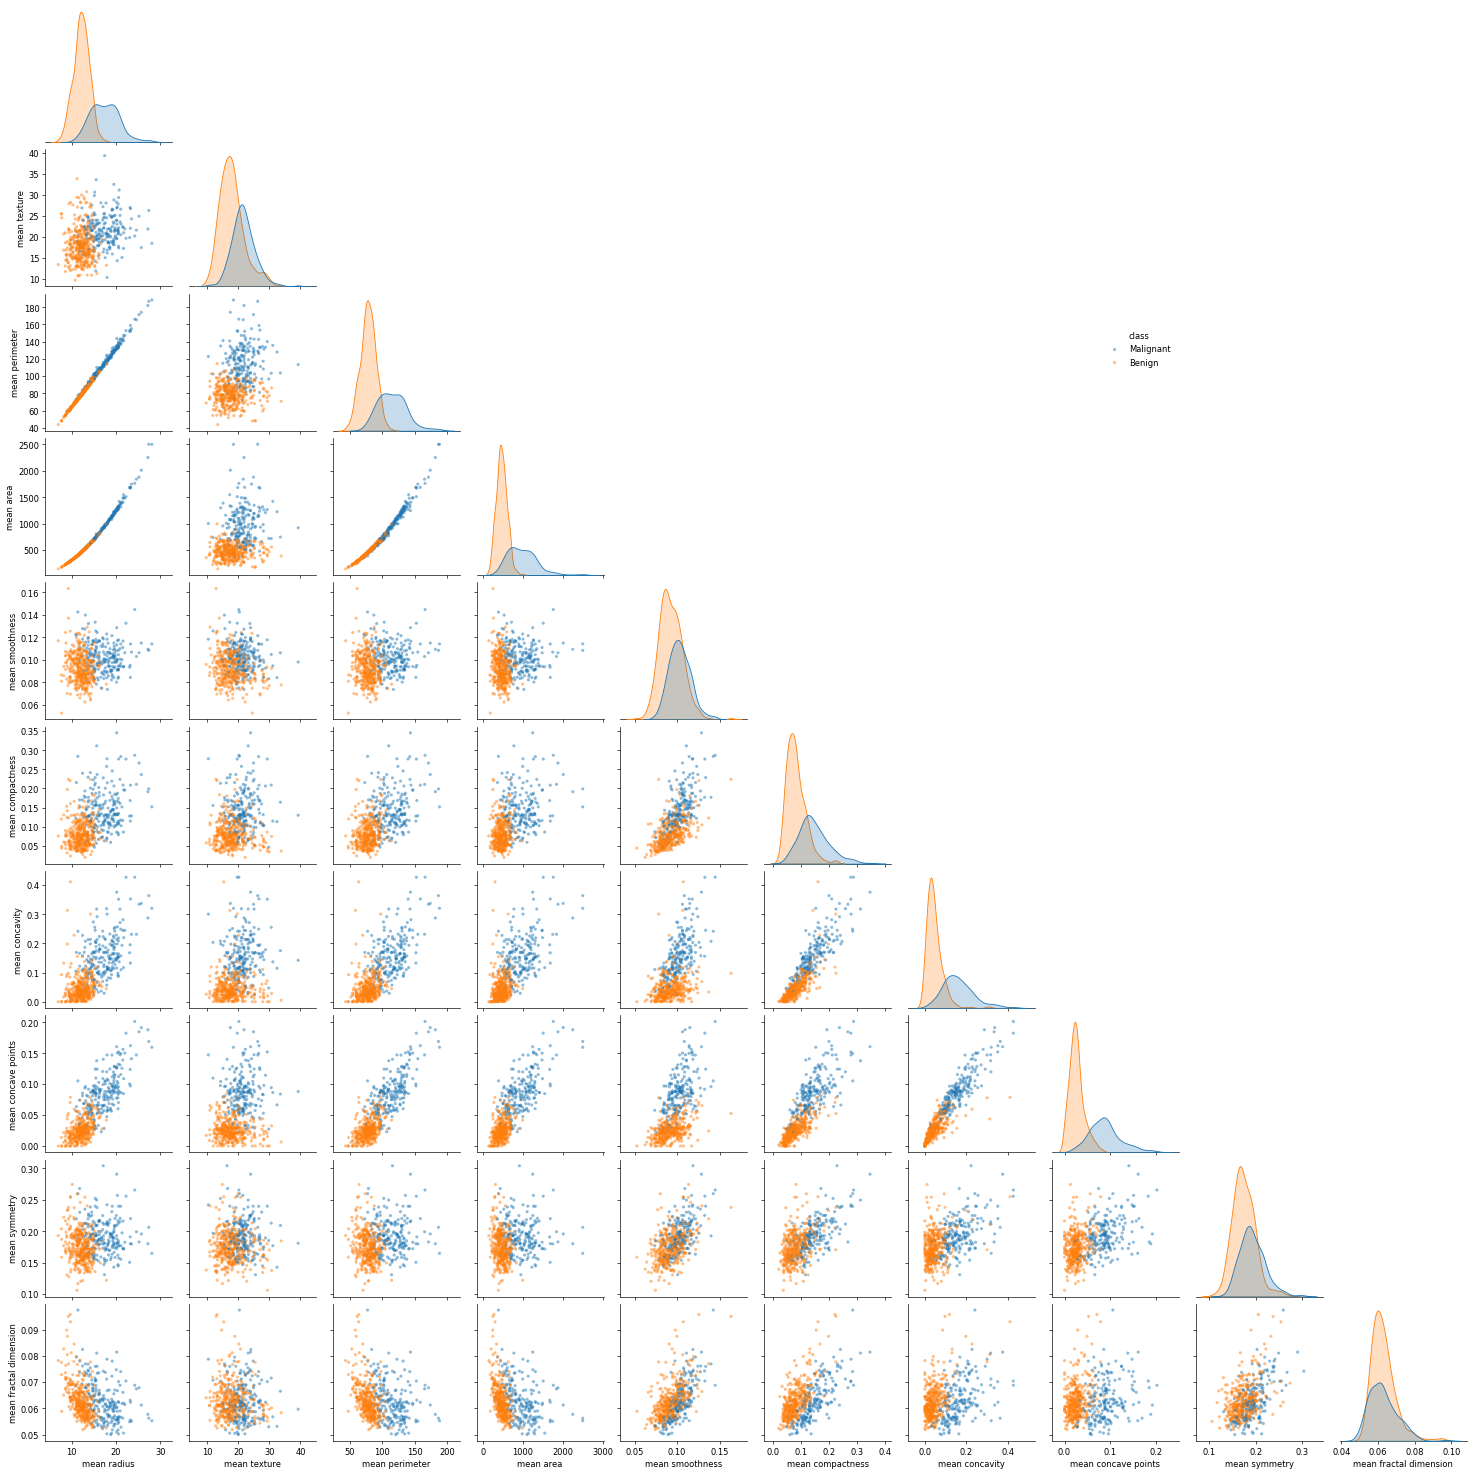

In [46]:
from sklearn.datasets import load_breast_cancer
ds = load_breast_cancer(as_frame=True)
df = ds.frame

df["class"] = df["target"].map({0: "Malignant", 1: "Benign"})

cols = [c for c in df.columns if c not in ["target", "class"]]
mean_cols  = [c for c in cols if c.startswith("mean ")]
plot_cols = mean_cols  # Just plot the "mean columns" (See wdbc.data)

g = sns.pairplot(
    df[plot_cols + ["class"]],
    hue="class",
    corner=True,
    diag_kind="kde",
    plot_kws=dict(s=14, alpha=0.50, linewidth=0)
)

g.figure.set_dpi(60)  # Change to 300 for recitation
g._legend.set_bbox_to_anchor((0.75,0.75))

plt.show()

### Wine Dataset

Load using sklearn

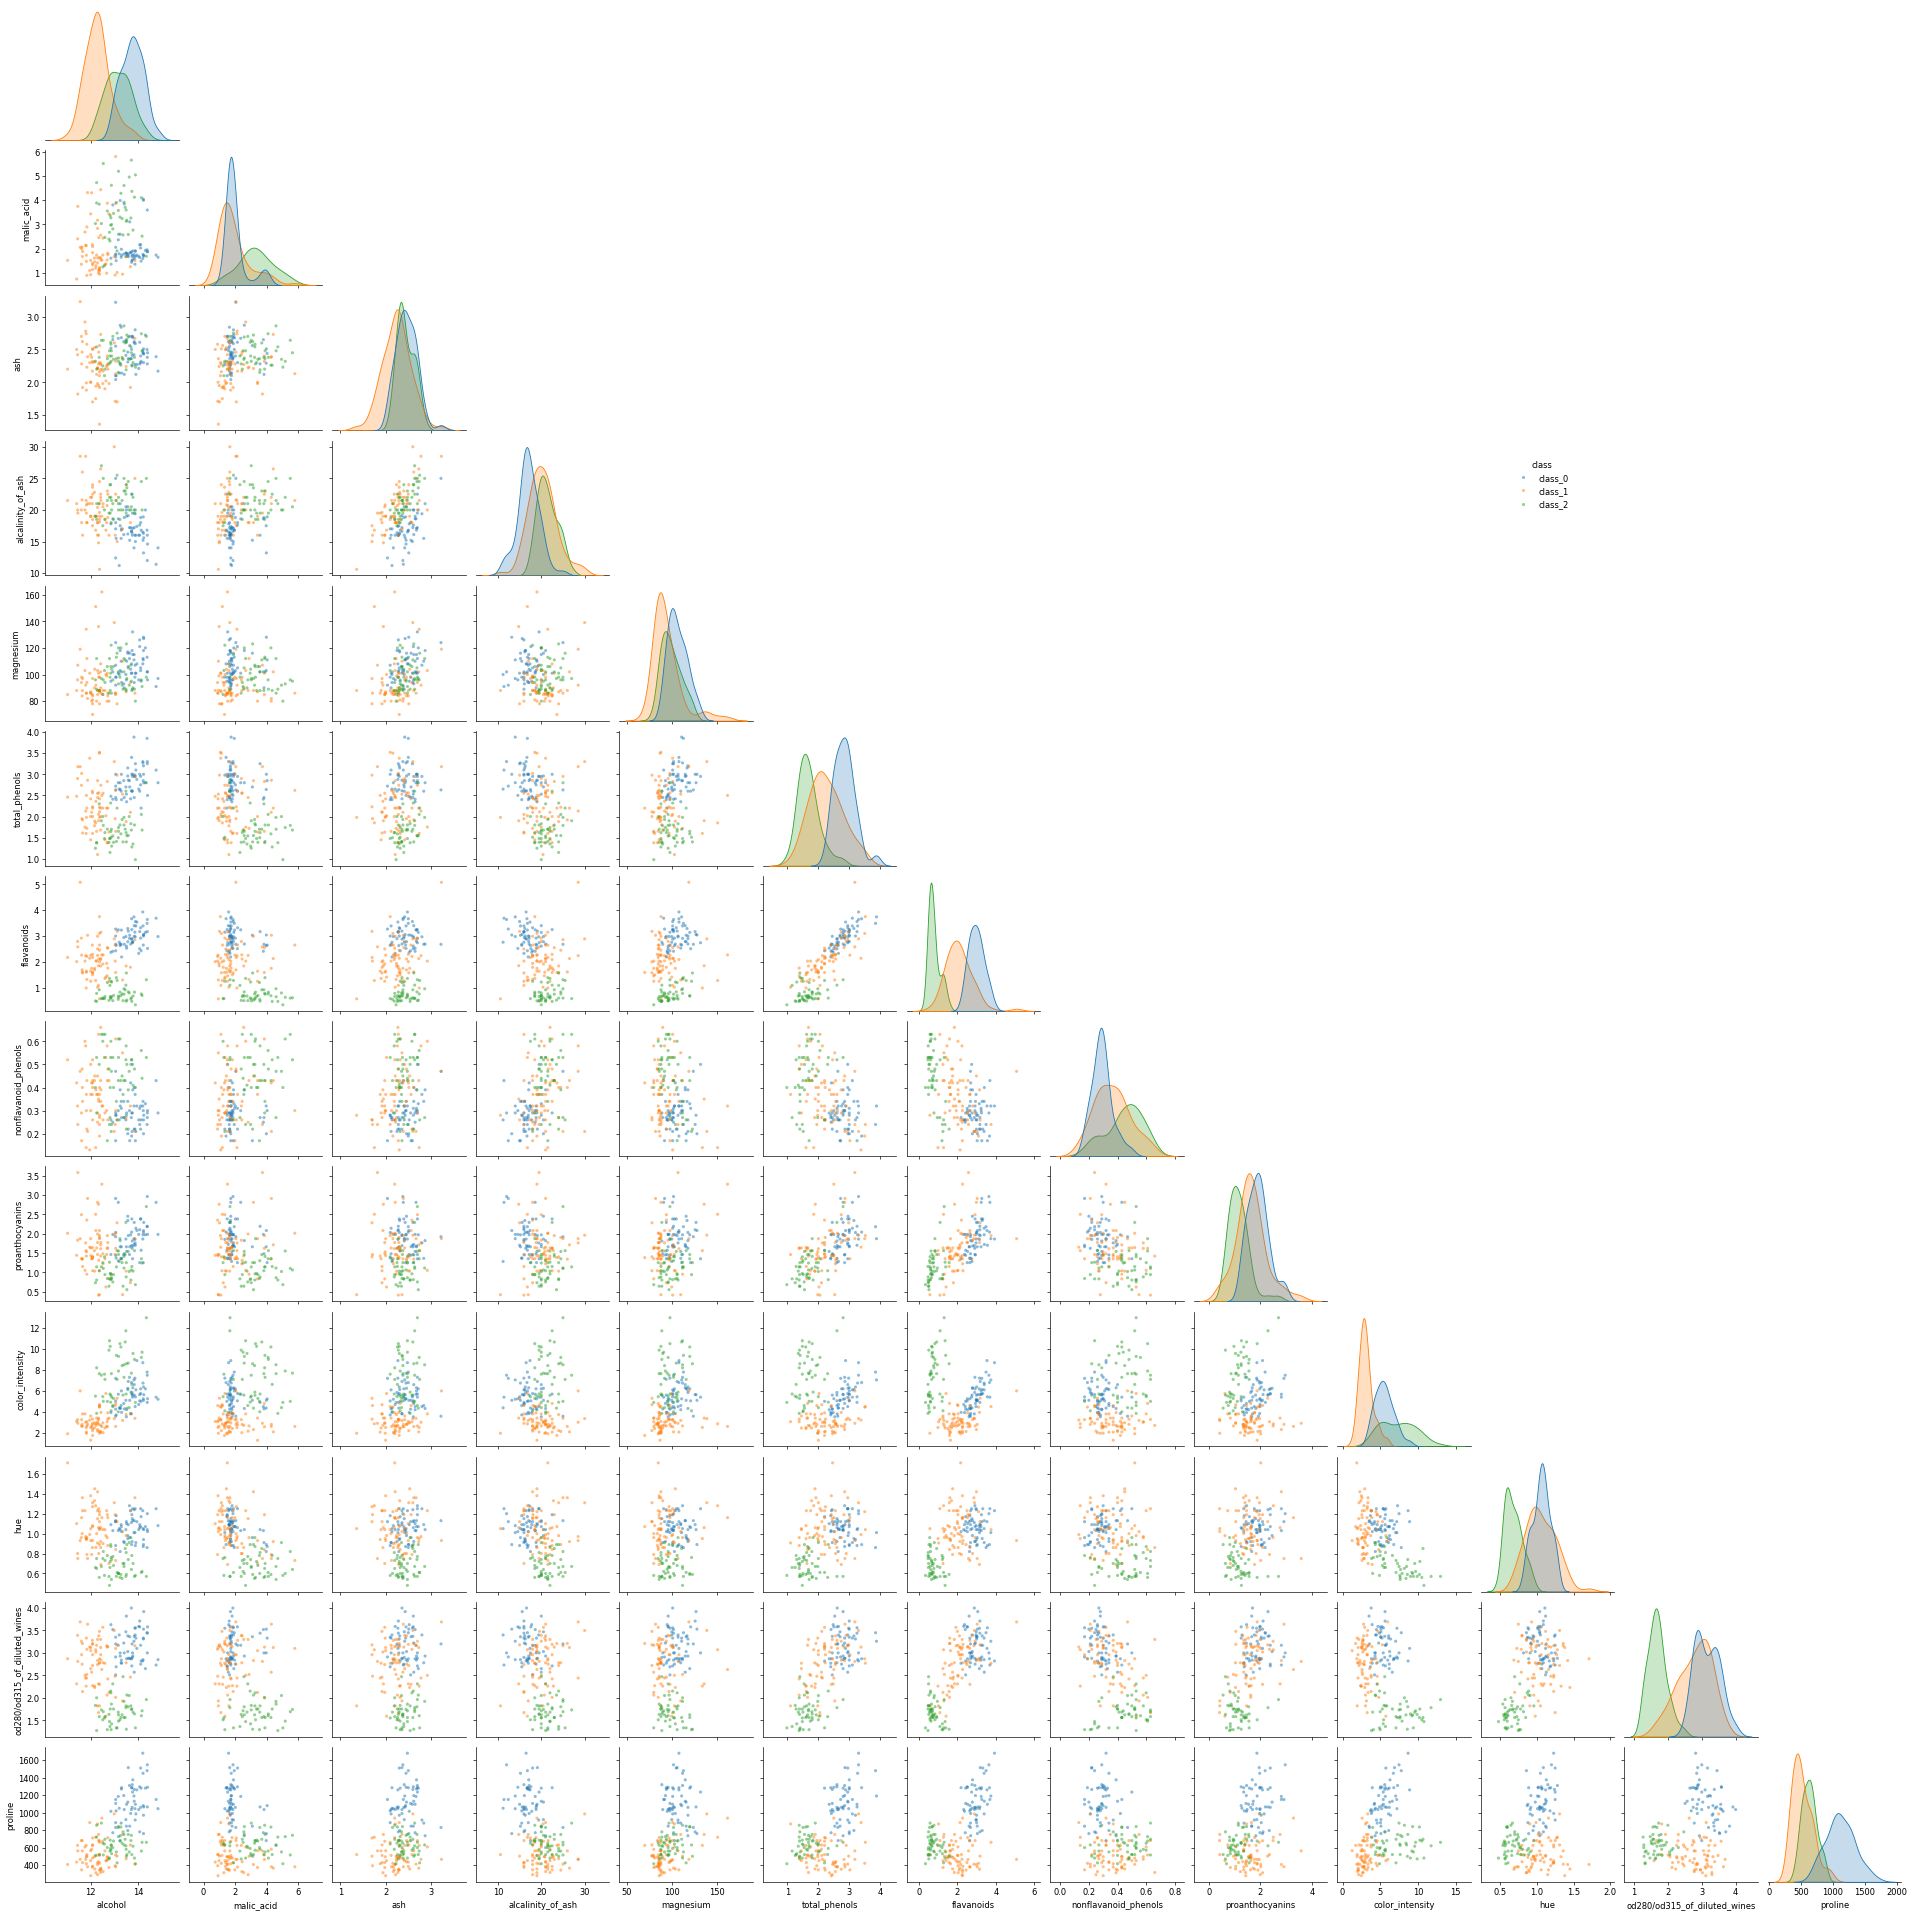

In [47]:
from sklearn.datasets import load_wine

ds = load_wine(as_frame=True)
df = ds.frame.copy()

# Map numeric target -> readable class names
df["class"] = df["target"].map(dict(enumerate(ds.target_names)))  # class_0, class_1, class_2

plot_cols = ds.feature_names  # 13 features

g = sns.pairplot(
    df[plot_cols + ["class"]],
    hue="class",
    corner=True,
    diag_kind="kde",
    plot_kws=dict(s=14, alpha=0.50, linewidth=0)
)

g.figure.set_dpi(60)
if g._legend is not None:
    g._legend.set_loc("upper left")
    g._legend.set_bbox_to_anchor((0.75, 0.75))

plt.show()


### Seeds Dataset

Loading directly from URL using Pandas (I didn't know this was possible!)

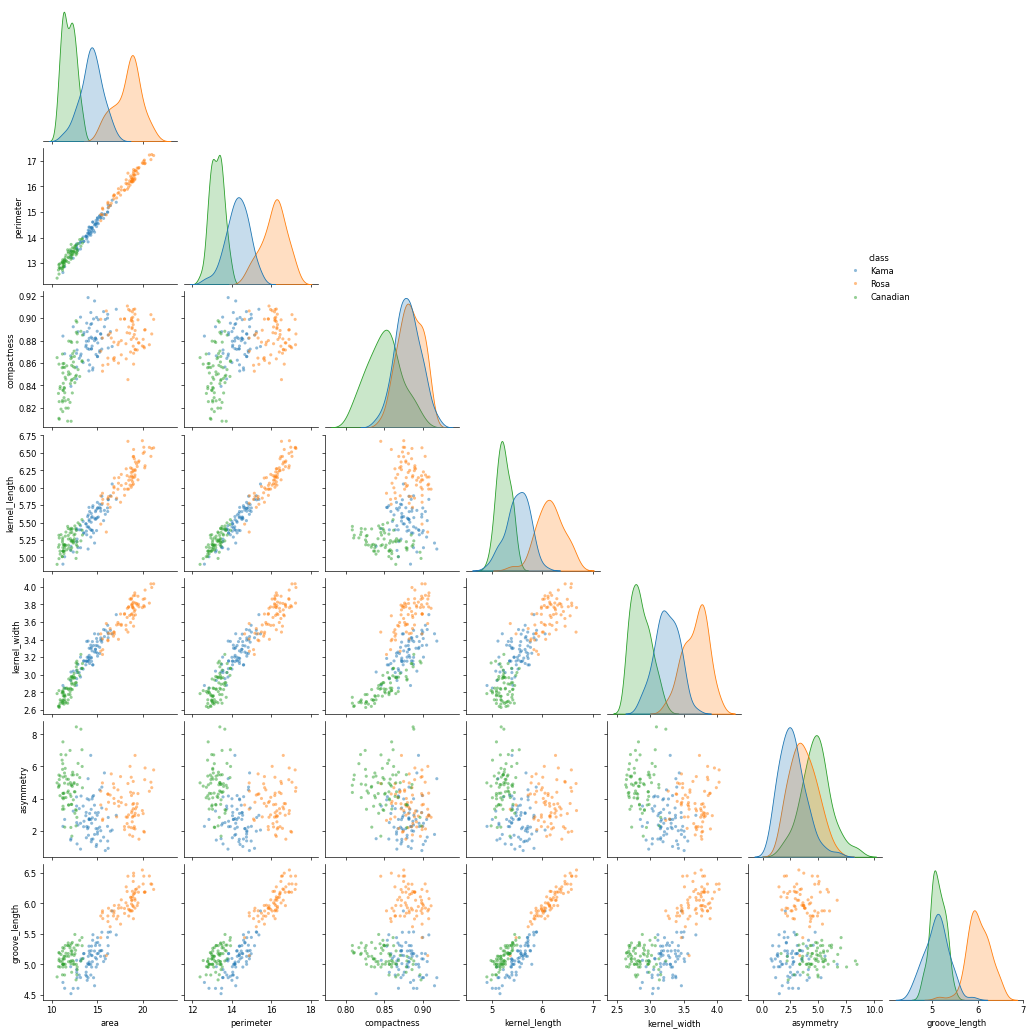

In [48]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
cols = [
    "area", "perimeter", "compactness", "kernel_length", "kernel_width",
    "asymmetry", "groove_length", "class_id"
]
df = pd.read_csv(url, sep=r"\s+", header=None, names=cols)

# Map 1/2/3 -> cultivar names from the dataset description
df["class"] = df["class_id"].map({1: "Kama", 2: "Rosa", 3: "Canadian"})
plot_cols = cols[:-1]  # the 7 numeric features

g = sns.pairplot(
    df[plot_cols + ["class"]],
    hue="class",
    corner=True,
    diag_kind="kde",
    plot_kws=dict(s=14, alpha=0.50, linewidth=0)
)

g.figure.set_dpi(60)
if g._legend is not None:
    g._legend.set_loc("upper left")
    g._legend.set_bbox_to_anchor((0.75, 0.75))

plt.show()

# Picking a dataset

I'm leaning towards the seeds dataset, and looking at asymmetry vs perimeter for Kama vs others

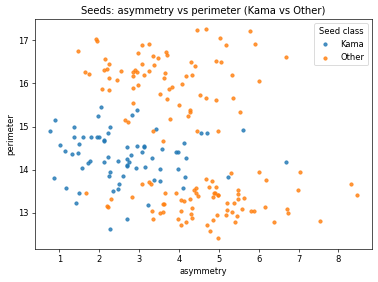

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
cols = [
    "area", "perimeter", "compactness", "kernel_length", "kernel_width",
    "asymmetry", "groove_length", "class_id"
]
df = pd.read_csv(url, sep=r"\s+", header=None, names=cols)

x1 = df["asymmetry"].to_numpy(dtype=float)
x2 = df["perimeter"].to_numpy(dtype=float)

# Labels; We want either "is Kama" or otherwise
target = (df["class_id"].to_numpy() == 1)

fig = plt.figure(dpi=60)
ax = fig.add_subplot(111)
ax.scatter(x1[target],  x2[target],  s=16, alpha=0.8, label="Kama")
ax.scatter(x1[~target], x2[~target], s=16, alpha=0.8, label="Other")

ax.set_xlabel("asymmetry")
ax.set_ylabel("perimeter")
ax.set_title("Seeds: asymmetry vs perimeter (Kama vs Other)")
ax.legend(loc="upper right", title="Seed class")
plt.tight_layout()
plt.show()

# Gaussian Kernel Discussion & Needed Math

On the board!

# Using scikit-learn for a Gaussian SVM

### Very direct

Sci-kit learn has a Gaussian kernel built-in (referred to with the umbrella term "radial basis function")

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [51]:
# Make test / train split
X  = np.column_stack([x1, x2])
y = target.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0
)

In [52]:
# sigma = 1e-3
sigma = 1e-1
# sigma = 1
# sigma = 1e5

clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma="scale", C=sigma)  # Gaussian kernel
)
clf.fit(X_train, y_train)

print("Train accuracy:", clf.score(X_train, y_train))
print("Test  accuracy:", clf.score(X_test,  y_test))

Train accuracy: 0.8471337579617835
Test  accuracy: 0.8867924528301887


### Display results

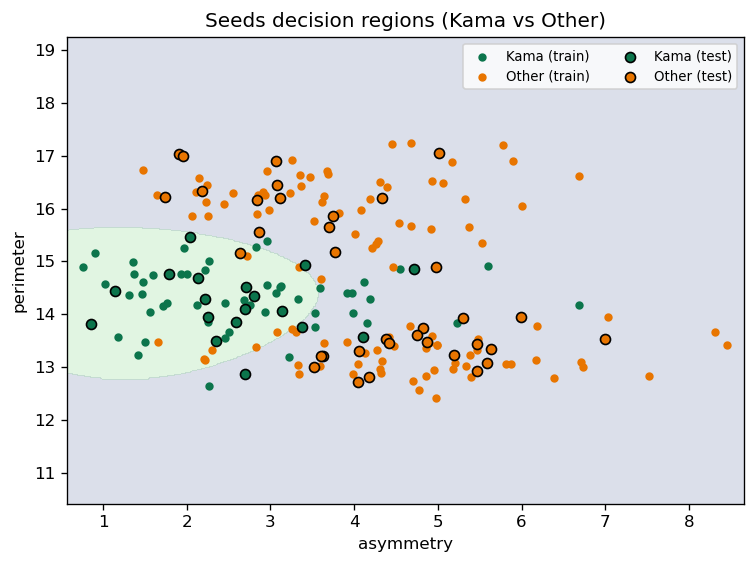

In [53]:
# Make a grid over the feature space
x1_min, x1_max = X[:,0].min() - 0.2, X[:,0].max() + 0.2
x2_min, x2_max = X[:,1].min() - 2.0, X[:,1].max() + 2.0
xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 400),
    np.linspace(x2_min, x2_max, 400)
)
grid = np.c_[xx1.ravel(), xx2.ravel()]
Z = clf.predict(grid).reshape(xx1.shape)

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

# Light background for the two classes
ax.contourf(xx1, xx2, Z, alpha=0.18, levels=[-0.5, 0.5, 1.5])

# Colors
c_k = "#0C754C"
c_o = "#e87500"

# Training points
is_kama_tr = (y_train == 1)
ax.scatter(X_train[is_kama_tr,0],  X_train[is_kama_tr,1],  s=16, facecolors=c_k, label="Kama (train)")
ax.scatter(X_train[~is_kama_tr,0], X_train[~is_kama_tr,1], s=16, facecolors=c_o, label="Other (train)")

# Test points (hollow markers)
is_kama_te = (y_test == 1)
ax.scatter(X_test[is_kama_te,0],   X_test[is_kama_te,1],   s=36, facecolors=c_k, edgecolors="k", label="Kama (test)")
ax.scatter(X_test[~is_kama_te,0],  X_test[~is_kama_te,1],  s=36, facecolors=c_o, edgecolors="k", label="Other (test)")

ax.set_xlabel("asymmetry")
ax.set_ylabel("perimeter")
ax.set_title("Seeds decision regions (Kama vs Other)")
ax.legend(loc="upper right", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

### Other

This leans on scikit-learn more than I'd like. I hope to see if I can separate out "applying a kernel" from the "SVM".